Jane Downer<br>
A20452471<br>
CS 577<br>
Assignment 3<br>
10/25/2022


In [198]:
#link to models:
classification_model_url = 'https://drive.google.com/drive/u/0/folders/14TmARr74X2F8t11MzxkeVtwOVIz7BVO9'
regression_model_url = 'https://drive.google.com/drive/u/0/folders/14TmARr74X2F8t11MzxkeVtwOVIz7BVO9'

### Set these paths to the desired locations:

In [197]:
ROOT_PATH = '/content/MyDrive/MyDrive/2022 files/CS 577/Assignments/hw3'
regression_model_location = f'{ROOT_PATH}/Regression_regularization_models/best_model.tf'
classification_model_location = f'{ROOT_PATH}/Classification_regularization_models/best_model.tf'

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [161]:
import os
import sys
import time
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
import shutil
import tensorflow.keras.utils as np_utils


from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta, Adam
import tensorflow.keras.losses as losses
import datetime as dt
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score



from_tensor_slices = tf.data.Dataset.from_tensor_slices


In [ ]:
os.chdir(ROOT_PATH)

#1. Identify data sets

In [ ]:
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
community_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data"

#2. Load data, clean, vectorize, and split into train/test/validation sets.

### Load, prep, and clean, and split data

In [ ]:
imp = SimpleImputer(missing_values=np.NAN, strategy='mean')


def load_iris(url):
    data = pd.read_csv(url,header=None)
    data = data.replace("?",np.NAN)
    data = data.sample(frac=1).reset_index(drop=True).values
    X_trn, X_tst = data[100:,:4].astype("float"), data[:100,:4].astype("float")
    y_trn, y_tst =  np.asmatrix(pd.get_dummies(data[100:,4])),  np.asmatrix(pd.get_dummies(data[:100,4]))
    return (X_trn,y_trn),(X_tst,y_tst)
    
def load_community(url):
    data = pd.read_csv(url,header=None)
    data = data.replace("?",np.NAN).values
    X_trn, X_tst = data[:1500,5:127].astype("float"), data[1500:,5:127].astype("float")
    y_trn, y_tst = data[:1500,127:128].astype("float"), data[1500:,127:128].astype("float")
    X_trn, X_tst = imp.fit_transform(X_trn), imp.fit_transform(X_tst)
    y_trn, y_tst = imp.fit_transform(y_trn), imp.fit_transform(y_tst)
    return (X_trn,y_trn),(X_trn,y_trn)

(X_trn_iris,y_trn_iris),(X_tst_iris,y_tst_iris) = load_iris(iris_url)
(X_trn_community,y_trn_community),(X_tst_community,y_tst_community) = load_community(community_url)


In [ ]:
print(f'Some Iris data:\n\n{X_trn_iris[:1]}\n{y_trn_iris[:1]}')
print(f'\nSome Communities data:\n\n{X_trn_community[:1]}\n{y_trn_community[:1]}')

Some Iris data:

[[5.2 3.4 1.4 0.2]]
[[1 0 0]]

Some Communities data:

[[0.19 0.33 0.02 0.9  0.12 0.17 0.34 0.47 0.29 0.32 0.2  1.   0.37 0.72
  0.34 0.6  0.29 0.15 0.43 0.39 0.4  0.39 0.32 0.27 0.27 0.36 0.41 0.08
  0.19 0.1  0.18 0.48 0.27 0.68 0.23 0.41 0.25 0.52 0.68 0.4  0.75 0.75
  0.35 0.55 0.59 0.61 0.56 0.74 0.76 0.04 0.14 0.03 0.24 0.27 0.37 0.39
  0.07 0.07 0.08 0.08 0.89 0.06 0.14 0.13 0.33 0.39 0.28 0.55 0.09 0.51
  0.5  0.21 0.71 0.52 0.05 0.26 0.65 0.14 0.06 0.22 0.19 0.18 0.36 0.35
  0.38 0.34 0.38 0.46 0.25 0.04 0.   0.12 0.42 0.5  0.51 0.64 0.03 0.13
  0.96 0.17 0.06 0.18 0.44 0.13 0.94 0.93 0.03 0.07 0.1  0.07 0.02 0.57
  0.29 0.12 0.26 0.2  0.06 0.04 0.9  0.5  0.32 0.14]]
[[0.2]]


In [ ]:
# This block of code is borrowed:
# https://stackoverflow.com/questions/57181551/can-i-write-a-keras-callback-that-records-and-returns-the-total-training-time

from timeit import default_timer as timer


class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs=100):
        self.history=[]
        self.total_epochs=total_epochs
        self.elapsed=0
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.elapsed += (timer()-self.starttime)
        self.history.append(self.elapsed)
        print(f'\rEpoch {str(epoch+1)}/{str(self.total_epochs)}',end='')

In [ ]:
nesterov           = lambda lr, wd: SGD(learning_rate=lr, momentum=0.9,nesterov=True,decay=wd)
adagrad            = lambda lr, wd: Adadelta(learning_rate=lr, rho=0.9, epsilon=None, decay=wd)
rmsprop            = lambda lr, wd: RMSprop(learning_rate=lr, rho=0.95, epsilon=None, decay=wd)
adam               = lambda lr, wd: Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, decay=wd,amsgrad=False)
sgd                = lambda lr, wd: SGD(learning_rate=lr, decay=wd)

optimizers_     = {'SGD': sgd, 'Nesterov': nesterov, 'Adagrad': adagrad, 'RMSprop': rmsprop, 'Adam':adam}
regularization_ = {'BatchNorm': tf.keras.layers.BatchNormalization(), 'Dropout': tf.keras.layers.Dropout(0.5), 'Weight Decay': None}
cat_losses      = {'cat_cross_ent': 'categorical_crossentropy', 'cat_hinge': 'categorical_hinge',  'KL_div':'kullback_leibler_divergence'}
reg_losses      = {'MAE':'mae', 'MSE':'mse','Log-cosh':'logcosh'}
lrs             = [1e-01,1e-02,1e-03]
hidden_units    = [(64,32),(32,16)]
batch_sizes     = [16, 32, 64]

In [ ]:
for folder_names in ['Classification_loss_models','Classification_regularization_models','Classification_optimization_models',
                     'Regression_loss_models',' Regression_regularization_models','Regression_optimization_models']:
    folder_path = os.path.join(ROOT_PATH,folder_names)
    try:
        os.mkdir(folder_path)
    except:
        pass

# Classification -- Loss & Hyperparameter Search

In [ ]:
def print_out(epoch, time, loss_name, reg_type, h1, h2, lr, wd, BS):
      print(f'Epoch:      {epoch}\n'+
      f'Time:       {np.round(time,3)} seconds\n' +
      f'Loss_fn:    {loss_name}\n'+
      f'Reg. type:  {reg_type}\n'+
      f'(h1,h2):    ({h1},{h2})\n'+
      f'lr:         {lr}\n'+
      f'wgt. decay: {wd}\n' +
      f'batch size: {BS}\n')

In [ ]:
from matplotlib import axes
loss_task_model = lambda h1, h2, X_trn, k, act: tf.keras.models.Sequential([
                                                                            layers.Dense(h1,input_shape=(X_trn.shape[1],)),
                                                                            layers.Activation('relu'),
                                                                            layers.Dense(h2),
                                                                            layers.Activation('relu'),
                                                                            layers.Dense(k),
                                                                            layers.Activation(act)
                                                                            ])


def loss_task(X_trn, y_trn, loss_dict, task_name, k, act, E=50, wd=0, o_name='SGD',opt=sgd, ylim=1.5):
    all_models = {}
    j = 0
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
    fig.set_figheight(10)
    fig.set_figwidth(19)
    fig.suptitle(f'{task_name} -- Loss Functions & Hyperparameters', horizontalalignment='center', y=1.05)
    abs_min_loss, abs_min_epoch, abs_min_time, abs_min_params, abs_min_h1, abs_min_h2, abs_min_BS, abs_min_lr, abs_min_loss_name, abs_min_model = 100, 100, 100, '', 100, 100, 100, 100, '', None

    for i in range(len(list(loss_dict.items()))):
        (loss_name, loss_fn) = list(loss_dict.items())[i]

        ax[i,j].set_title(f'{loss_name}')
        ax[i,j].set_xlabel('Epoch')
        ax[i,j].set_ylabel('Validation Loss')
        ax[i,j].set_ylim(0, ylim)

        print('\n\n' + '*'*24)
        print(f'*** {loss_name} '.ljust(21) + '***')
        print('*'*24)
        for j in range(len(lrs)):
            min_loss, min_epoch, min_time, min_params, min_h1, min_h2, min_BS, min_lr, min_loss_name, min_model = 100, 100, 100, '', 100, 100, 100, 100, '', None
            ax[i,j].set_title(f'{loss_name}_{lrs[j]}')
            ax[i,j].set_xlabel('Epoch')
            ax[i,j].set_ylabel('Validation Loss')
            ax[i,j].set_ylim(0, ylim)

            lr = lrs[j]
            for (h1,h2) in hidden_units:
                for BS in batch_sizes:
                    print(f'lr: {lr} - batch_size: {BS}, hidden units: ({h1},{h2}) - opt: {o_name}')
                    cb = TimingCallback(total_epochs=E)

                    model = loss_task_model(h1,h2, X_trn,k,act)
                    model.compile(loss=loss_fn, metrics=['accuracy'], optimizer=opt(lr=lr,wd=wd))
                    pred = model.fit(X_trn, y_trn, epochs=E, batch_size=BS, validation_split=0.1, callbacks=[cb], verbose=0)
                    ax[i,j].plot(range(E),pred.history['val_loss'], label=f'h1,h2={h1},{h2}|BS={BS}')

                    these_params = f'{loss_name}_{lr}_{(h1,h2)}_{BS}'
                    best_epoch = np.argmin(pred.history['val_loss'])
                    best_loss = pred.history['val_loss'][best_epoch]
                    best_time = cb.history[best_epoch]

                    if (best_loss == min_loss and best_epoch < min_epoch) or (best_loss < min_loss):
                            min_model=model
                            min_params = these_params
                            min_epoch = best_epoch
                            min_loss = best_loss
                            min_loss_fn = loss_name
                            min_time = best_time
                            min_h1 = h1
                            min_h2 = h2
                            min_BS = BS
                            min_lr = lr

                    if (best_loss == abs_min_loss and best_epoch < abs_min_epoch) or (best_loss < abs_min_loss):
                            abs_min_model=model
                            abs_min_params = these_params
                            abs_min_epoch = best_epoch
                            abs_min_loss = best_loss
                            abs_min_loss_fn = loss_name
                            abs_min_time = best_time
                            abs_min_h1 = h1
                            abs_min_h2 = h2
                            abs_min_BS = BS
                            abs_min_lr = lr

                    print(': Min val loss - ' + f'{np.round(best_loss,3)}'.ljust(7)+ '- Time ' + f'{np.round(best_time,3)}' + '- Epoch ' + f'{best_epoch}'.ljust(3) )

                    this_dict = {'model': model,
                                'loss': pred.history['loss'],
                                'accuracy': pred.history['accuracy'],
                                'val_loss': pred.history['val_loss'],
                                'val_accuracy': pred.history['val_accuracy']}

                    all_models[these_params] = this_dict

                    #min_model.save(f'{ROOT_PATH}/{task_name}_loss_models/best_model.tf')         
            best_label = 'Earliest to converge'
            ax[i,j].scatter([min_epoch],[min_loss],label=best_label, color='red')
            ax[i,j].axhline(min_loss,color='black',linestyle='--',lw=0.5)
            if i+1==3 and j+1==3:
                ax[i,j].legend(bbox_to_anchor=(1.75, 0),loc = 'lower left')

    min_model.save(f'{ROOT_PATH}/{task_name}_loss_models/best_model.tf')         

    model.save(f'{ROOT_PATH}/{task_name}_optimization_models/model_{iter}.tf')
    fig.savefig(f'{ROOT_PATH}/{task_name}_loss_models/results.png')
    fig.tight_layout()
    fig.show()
    print(f'\nEarliest to converge:\n')
    print_out(abs_min_epoch, abs_min_time, abs_min_loss_fn, 'None', abs_min_h1, abs_min_h2, abs_min_lr, '0', abs_min_BS)




************************
*** cat_cross_ent    ***
************************
lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: SGD
Epoch 50/50: Min val loss - 0.1    - Time 1.317- Epoch 23 
lr: 0.1 - batch_size: 32, hidden units: (64,32) - opt: SGD
Epoch 50/50: Min val loss - 0.124  - Time 1.711- Epoch 39 
lr: 0.1 - batch_size: 64, hidden units: (64,32) - opt: SGD
Epoch 50/50: Min val loss - 0.207  - Time 1.889- Epoch 48 
lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: SGD
Epoch 50/50: Min val loss - 0.165  - Time 1.465- Epoch 31 
lr: 0.1 - batch_size: 32, hidden units: (32,16) - opt: SGD
Epoch 50/50: Min val loss - 0.146  - Time 0.923- Epoch 13 
lr: 0.1 - batch_size: 64, hidden units: (32,16) - opt: SGD
Epoch 50/50: Min val loss - 0.507  - Time 1.805- Epoch 49 
lr: 0.01 - batch_size: 16, hidden units: (64,32) - opt: SGD
Epoch 50/50: Min val loss - 0.389  - Time 1.87- Epoch 46 
lr: 0.01 - batch_size: 32, hidden units: (64,32) - opt: SGD
Epoch 50/50: Min val loss - 0.511  - 

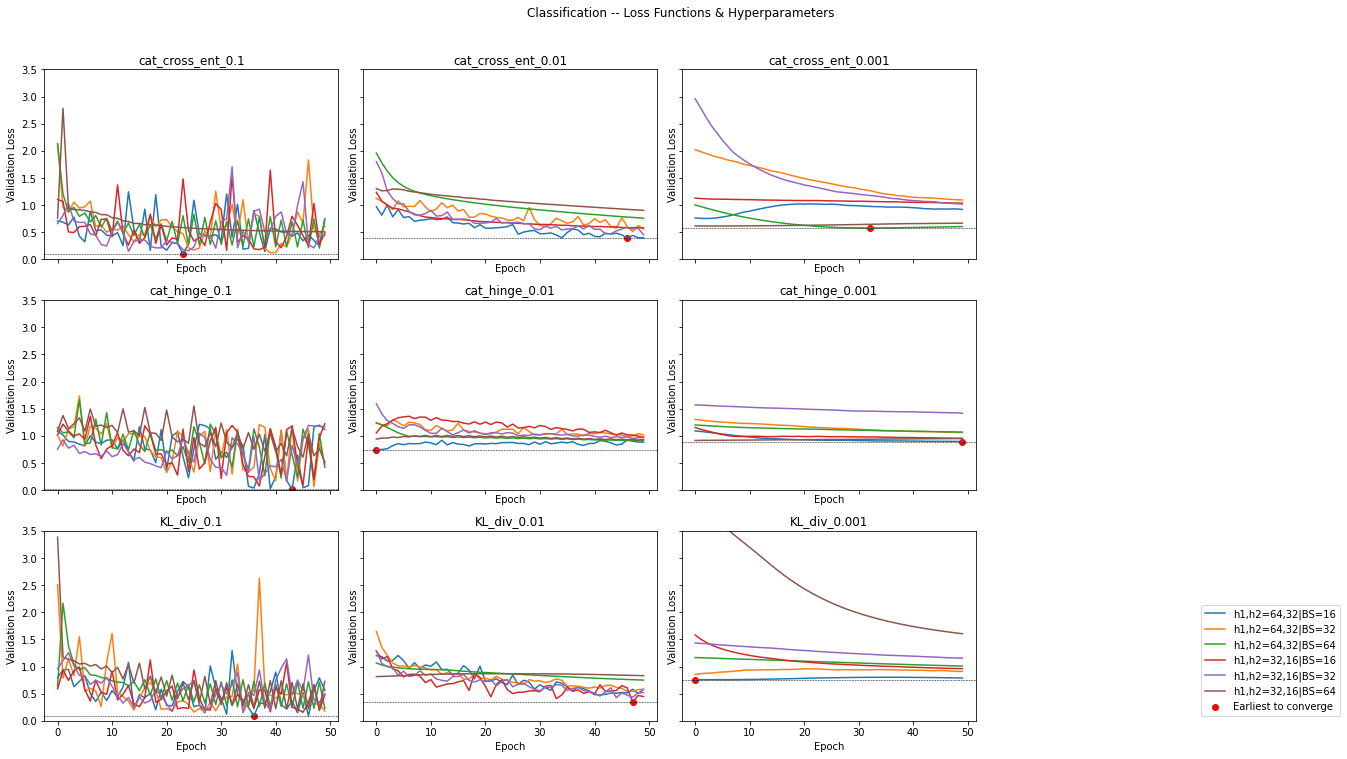

In [ ]:
loss_task(X_trn_iris, y_trn_iris, cat_losses, 'Classification', 3,'softmax', ylim=3.5,E=50)

# Classification -- Optimization

In [ ]:
opt_task_model = lambda h1, h2, X_trn, k, act: tf.keras.models.Sequential([layers.Dense(h1,input_shape=(X_trn.shape[1],)),
                                                                    layers.Activation('relu'),
                                                                    layers.Dense(h2),
                                                                    layers.Activation('relu'),
                                                                    layers.Dense(k),
                                                                    layers.Activation(act)])

def opt_task(X_trn, y_trn, E, wd, h1, h2, k, BS, lr, act, loss_name, loss_fn, task_name):
    all_models = {}
    chosen_opt_functions = []
    best_epochs = []
    best_losses = []
    best_times = []

    print('Repeating 3 times and comparing results -- randomization in training loop makes results inconsistent')
    fig = plt.figure(figsize=(19,5))
    fig.suptitle(f'{task_name} -- Optimization')
    for iter in range(3):
        min_loss, min_epoch, min_time, min_params, min_opt, min_model = 100, 100, 100, '', None, None
        ax = fig.add_subplot(1,3,iter+1)
        print(f'Trial {iter+1}')
        ax.set_title(f'Trial {iter+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Validation Loss')
        for (o_name, opt) in optimizers_.items():
            cb = TimingCallback(total_epochs=E)

            
            these_params = f'{loss_name}_{lr}_{(h1,h2)}_{BS}'
            print(f'lr: {lr} - batch_size: {BS}, hidden units: ({h1},{h2}) - opt: {o_name}')

            model = opt_task_model(h1,h2, X_trn,k,act)
            model.compile(loss=loss_fn, metrics=['accuracy'], optimizer=opt(lr=lr,wd=wd))
            pred = model.fit(X_trn, y_trn, epochs=E, batch_size=BS, validation_split=0.1, callbacks=[cb], verbose=0)

            this_dict = {'model': model,
                        'loss': pred.history['loss'],
                        'accuracy': pred.history['accuracy'],
                        'val_loss': pred.history['val_loss'],
                        'val_accuracy': pred.history['val_accuracy']}
            all_models[these_params] = this_dict
            
            best_epoch = np.argmin(pred.history['val_loss'])
            best_loss  = pred.history['val_loss'][best_epoch]
            best_time  = cb.history[best_epoch]
            best_opt   = o_name


            if (best_loss == min_loss and best_epoch < min_epoch) or (best_loss < min_loss):
                min_params, min_epoch, min_loss, min_time, min_opt, min_model = these_params, best_epoch, best_loss, best_time, best_opt, model

            print('>>> Min val loss - ' + f'{np.round(best_loss,3)}'.ljust(7)+ '- Time ' + f'{np.round(best_time,3)}' + '- Epoch ' + f'{best_epoch}'.ljust(3) )

            ax.plot(range(E),pred.history['val_loss'],label=o_name)

        chosen_opt_functions.append(min_opt)
        best_epochs.append(min_epoch)
        best_losses.append(min_loss)
        best_times.append(min_time)
        
        ax.scatter([min_epoch],[min_loss],label='Min val loss',color='red')
        ax.axvline(min_epoch,linestyle=':',lw=0.5)
        if iter+1==3:
            ax.legend(bbox_to_anchor=(1.05, 0),loc = 'lower left')

        model.save(f'{ROOT_PATH}/{task_name}_optimization_models/model_{iter}.tf')
    
    fig.savefig(f'{ROOT_PATH}/{task_name}_optimization_models/results.png')
    fig.show()

    best_of_3_opt   = max(set(chosen_opt_functions), key=chosen_opt_functions.count)
    avg_of_3_losses = np.round(np.average(best_losses),3)
    avg_of_3_epochs = np.round(np.average(best_epochs),3)
    avg_of_3_times   = np.round(np.average(best_times),3)

    print(f'\nEarliest Optimizers to Converge: {min_opt}\n\n\n' +  
        f'Best of 3:\n\n'+
        f'Avg. minimum loss:           {avg_of_3_losses}\n'+
        f'Avg. epoch at min loss:      {avg_of_3_epochs}\n'+
        f'Avg. time at min loss:       {avg_of_3_times}\n'+
        f'Most common best optimizer:  {best_of_3_opt}\n\n'+

        f'Best overall:\n\n'+
        f'Best loss:                    {np.round(min_loss,3)}\n'+
        f'Epoch at min loss:            {min_epoch}\n'+
        f'Time at min loss:             {np.round(min_time,3)} seconds\n\n' +

        f'Hyperparameters:\n\n'+
        
        f'Loss_fn:    {loss_name}\n'+
        f'Reg. type:  None\n'+
        f'(h1,h2):    ({h1},{h2})\n'+
        f'lr:         {lr}\n'+
        f'wgt. decay: {wd}\n' +
        f'batch size: {BS}\n')

Repeating 3 times and comparing results -- randomization in training loop makes results inconsistent
Trial 1
lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: SGD
Epoch 50/50>>> Min val loss - 0.111  - Time 2.122- Epoch 48 
lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: Nesterov
Epoch 50/50>>> Min val loss - 0.898  - Time 0.606- Epoch 0  
lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: Adagrad
Epoch 50/50>>> Min val loss - 0.983  - Time 2.173- Epoch 49 
lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: RMSprop
Epoch 50/50>>> Min val loss - 1.052  - Time 2.243- Epoch 43 
lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: Adam
Epoch 50/50>>> Min val loss - 0.396  - Time 2.248- Epoch 49 
Trial 2
lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: SGD
Epoch 50/50>>> Min val loss - 0.144  - Time 2.04- Epoch 44 
lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: Nesterov
Epoch 50/50>>> Min val loss - 0.011  - Time 1.605- Epoch 30 
lr: 0.1 - batch_size: 16,

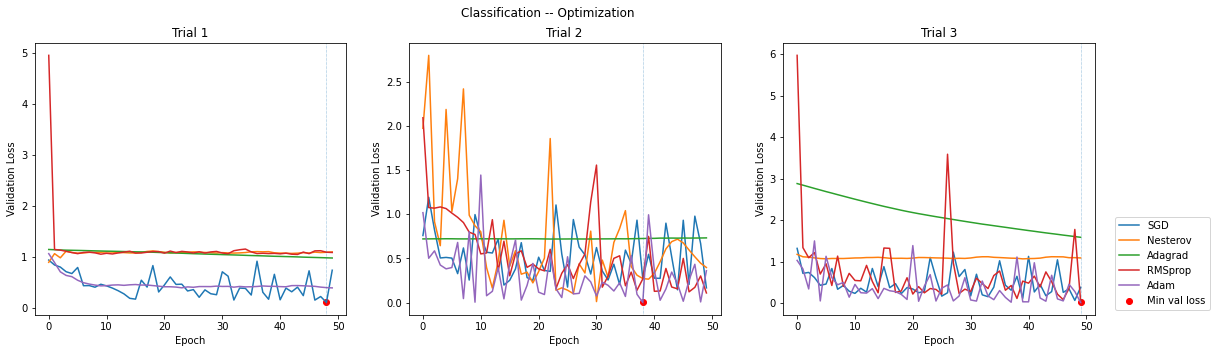

In [ ]:
opt_task(X_trn_iris, y_trn_iris, 50, 0, 32, 16, 3, 16, 0.1, 'softmax', 'cat_cross_ent', 'categorical_crossentropy', 'Classification')

Results vary due to randomness. When I ran the code, here were the results:

Out of 3 trials, the best optimizer was Adam.
- Average minimum loss: 0.087
- Average elapsed time to minimum loss: 2.319
- Average elapsed epochs at minimum loss: 44.0

# Classification - Regularization

In [ ]:
# Building regularization models + Prepping for Ensemble method

# WD
wd_model = lambda h1, h2, X_trn, k, act :models.Sequential([layers.Dense(h1,input_shape=(X_trn.shape[1],)),
                                                 layers.Activation('relu'),
                                                 layers.Dense(h2),
                                                 layers.Activation('relu'),
                                                 layers.Dense(k),
                                                 layers.Activation(act)])

# Batchnorm
bn_model = lambda h1, h2, X_trn, k, act :models.Sequential([layers.Dense(h1,input_shape=(X_trn.shape[1],)),
                                                 layers.BatchNormalization(),
                                                 layers.Activation('relu'),
                                                 layers.Dense(h2),
                                                 layers.BatchNormalization(),
                                                 layers.Activation('relu'),
                                                 layers.Dense(k),
                                                 layers.Activation(act)])


# Dropout
drop_model = lambda h1, h2, X_trn, k, act :models.Sequential([layers.Dense(h1,input_shape=(X_trn.shape[1],)),
                                                    layers.Activation('relu'),
                                                    layers.Dropout(0.5),
                                                    layers.Dense(h2),
                                                    layers.Activation('relu'),
                                                    layers.Dropout(0.5),
                                                    layers.Dense(k),
                                                    layers.Activation(act)])


# wd+bn+drop
wd_bn_drop_model = lambda h1, h2, X_trn, k, act :models.Sequential([layers.Dense(h1,input_shape=(X_trn.shape[1],)),
                                                                    layers.BatchNormalization(),
                                                                    layers.Activation('relu'),
                                                                    layers.Dropout(0.5),
                                                                    layers.Dense(h2),
                                                                    layers.BatchNormalization(),
                                                                    layers.Activation('relu'),
                                                                    layers.Dropout(0.5),
                                                                    layers.Dense(k),
                                                                    layers.Activation(act)])

In [ ]:
def reg_task(X_trn, y_trn,task_name,loss_fn,loss_name,lr,BS,h1,h2,k,act,E=50,o_name='Adam',opt=adam):
    # Classification Regularization Models
    folder_path = f'{ROOT_PATH}/{task_name}_regularization_models'
    all_models = {}
    wd = 0
    model_fn = None
    ensemble_model = None
    plt.figure(figsize=(14,5))
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title(f'{task_name} -- Regularization')
    min_loss, min_epoch, min_time, min_params, min_reg, min_model = 100, 100, 100, '', '', wd_model(h1,h2,X_trn,k,act)
    for (reg_type,model_fn) in [('None', wd_model),
                                ('WeightDecay', wd_model), 
                                            ('BatchNorm', bn_model), 
                                            ('Dropout', drop_model), 
                                            ('wd+BN+drop', wd_bn_drop_model), 
                                            ('Ensemble',None)]:
        if reg_type == 'Ensemble':
            m0 = tf.keras.models.load_model(f'{folder_path}/None_{task_name}_model.tf', compile=False) 
            m1 = tf.keras.models.load_model(f'{folder_path}/WeightDecay_{task_name}_model.tf', compile=False) 
            m2 = tf.keras.models.load_model(f'{folder_path}/BatchNorm_{task_name}_model.tf', compile=False) 
            m3 = tf.keras.models.load_model(f'{folder_path}/Dropout_{task_name}_model.tf', compile=False) 
            m4 = tf.keras.models.load_model(f'{folder_path}/wd+BN+drop_{task_name}_model.tf', compile=False) 
            m0._name, m1._name, m2._name, m3._name, m4._name = 'None','WeightDecay', 'BatchNorm', 'Dropout', 'wd_BN_drop'
            these_models = [m1, m2, m3, m4]
            model_input = tf.keras.Input(shape=(X_trn.shape[1],))
            model_outputs = [model(model_input) for model in these_models]
            ensemble_model = tf.keras.Model(inputs=model_input, outputs= tf.keras.layers.Average()(model_outputs))
            print(ensemble_model(model_input))

        cb = TimingCallback(total_epochs=E)
        print(f'reg: {reg_type} - lr: {lr} - batch_size: {BS}, hidden units: ({h1},{h2}) - opt: {o_name}')

        these_params = f'{loss_name}_{lr}_{(h1,h2)}_{BS}'
        if reg_type == 'WeightDecay':
            wd = 1e-06
        else:
            wd = 0
        if reg_type == 'Ensemble':
            model = ensemble_model
        else:
            model = model_fn(h1,h2,X_trn,k,act)
        model.compile(loss=loss_fn, metrics=['accuracy'], optimizer=opt(lr=lr,wd=wd))
        pred = model.fit(X_trn, y_trn, epochs=E, batch_size=BS, validation_split=0.1, callbacks=[cb], verbose=0)
        
        plt.plot(range(E),pred.history['val_loss'],label=reg_type)
        best_epoch = np.argmin(pred.history['val_loss'])
        best_loss = min(pred.history['val_loss'])
        best_time = cb.history[best_epoch]

        if (np.abs(best_loss-min_loss) < 0.01 and best_epoch < min_epoch) or (best_loss < min_loss):
            min_params, min_epoch, min_loss, min_time, min_reg, min_model = these_params, best_epoch, best_loss, best_time, reg_type, model

        print('\n' + 'Min val loss - ' + f'{np.round(best_loss,3)}'.ljust(7)+ '- Time ' + f'{np.round(best_time,3)}' + '- Epoch ' + f'{best_epoch}'.ljust(3) )

        this_dict = {'model': model,
                    'loss': pred.history['loss'],
                    'accuracy': pred.history['accuracy'],
                    'val_loss': pred.history['val_loss'],
                    'val_accuracy': pred.history['val_accuracy']}
        all_models[these_params] = this_dict
    
        model.save(f"{folder_path}/{reg_type}_{task_name}_model.tf")
    min_model.save(f"{folder_path}/best_model.tf")
    plt.scatter([min_epoch],[min_loss],label=min_params, color='red')
    plt.legend(bbox_to_anchor=(1.05, 0),loc = 'lower left')
    plt.savefig(f"{folder_path}/results.png")
    plt.show()

    print(f'\nEarliest regularization method to converge: {min_reg}\n\n')
    print_out(min_epoch, min_time, loss_name, reg_type, h1, h2, lr, wd, BS)
    print(f'\nBest loss score: {np.round(min_loss,3)}')

reg: None - lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: Adam
Epoch 50/50
Min val loss - 0.218  - Time 1.578- Epoch 27 
reg: WeightDecay - lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: Adam
Epoch 50/50
Min val loss - 0.008  - Time 1.936- Epoch 40 
reg: BatchNorm - lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: Adam
Epoch 50/50
Min val loss - 0.16   - Time 2.742- Epoch 43 
reg: Dropout - lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: Adam
Epoch 50/50
Min val loss - 0.185  - Time 2.153- Epoch 41 
reg: wd+BN+drop - lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: Adam
Epoch 50/50
Min val loss - 0.625  - Time 2.78- Epoch 43 
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='model_24/average_24/truediv:0', description="created by layer 'model_24'")
reg: Ensemble - lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: Adam
Epoch 50/50
Min val loss - 0.357  - Time 2.385- Epoch 0  


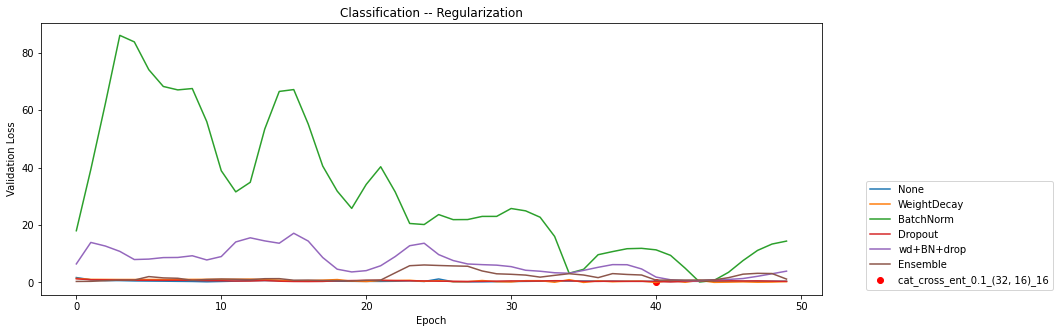


Earliest regularization method to converge: WeightDecay


Epoch:      40
Time:       1.936 seconds
Loss_fn:    cat_cross_ent
Reg. type:  Ensemble
(h1,h2):    (32,16)
lr:         0.1
wgt. decay: 0
batch size: 16


Best loss score: 0.008


In [ ]:
reg_task(X_trn_iris, y_trn_iris,'Classification','categorical_crossentropy','cat_cross_ent', 0.1,16,32,16,3,'softmax',50,'Adam',adam)

# Best Classification model

In [184]:
best_clf_model = models.load_model(classification_model_location)

best_clf_model.evaluate(X_tst_iris, y_tst_iris)

4/4 [==============================] - 0s 3ms/step - loss: 0.0683 - accuracy: 0.9700


[0.0683361068367958, 0.9700000286102295]

# Regression -- Loss & Hyperparameter Search
- Iterating through several loss functions, learning rates, \#epochs, \# hidden units, batch sizes
- Default optimizer: SGD
- No weight decay or regularization



************************
*** MAE              ***
************************
lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: SGD
Epoch 50/50: Min val loss - 0.081  - Time 5.971- Epoch 35 
lr: 0.1 - batch_size: 32, hidden units: (64,32) - opt: SGD
Epoch 50/50: Min val loss - 0.084  - Time 3.319- Epoch 29 
lr: 0.1 - batch_size: 64, hidden units: (64,32) - opt: SGD
Epoch 50/50: Min val loss - 0.084  - Time 2.926- Epoch 37 
lr: 0.1 - batch_size: 16, hidden units: (32,16) - opt: SGD
Epoch 50/50: Min val loss - 0.078  - Time 7.801- Epoch 49 
lr: 0.1 - batch_size: 32, hidden units: (32,16) - opt: SGD
Epoch 50/50: Min val loss - 0.084  - Time 4.271- Epoch 41 
lr: 0.1 - batch_size: 64, hidden units: (32,16) - opt: SGD
Epoch 50/50: Min val loss - 0.084  - Time 3.233- Epoch 43 
lr: 0.01 - batch_size: 16, hidden units: (64,32) - opt: SGD
Epoch 50/50: Min val loss - 0.086  - Time 6.71- Epoch 41 
lr: 0.01 - batch_size: 32, hidden units: (64,32) - opt: SGD
Epoch 50/50: Min val loss - 0.086  - 

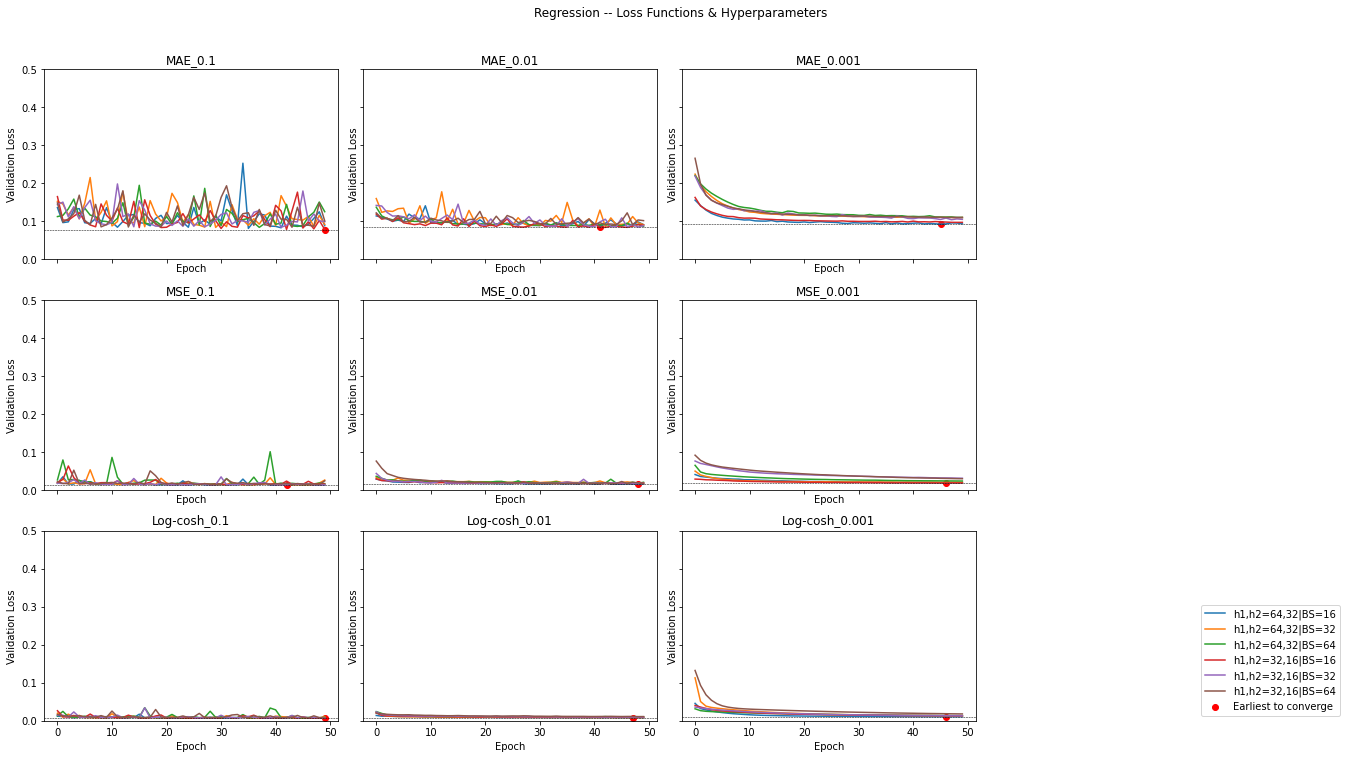

In [ ]:
loss_task(X_trn_community, y_trn_community, reg_losses, 'Regression', 1, 'linear', ylim=0.5)

# Regression -- Optimization Search
#### Using best loss function and hyperparameters found above

Repeating 3 times and comparing results -- randomization in training loop makes results inconsistent
Trial 1
lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: SGD
Epoch 50/50>>> Min val loss - 0.007  - Time 8.468- Epoch 48 
lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: Nesterov
Epoch 50/50>>> Min val loss - 0.006  - Time 7.657- Epoch 43 
lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: Adagrad
Epoch 50/50>>> Min val loss - 0.007  - Time 6.916- Epoch 39 
lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: RMSprop
Epoch 50/50>>> Min val loss - 0.02   - Time 8.694- Epoch 46 
lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: Adam
Epoch 50/50>>> Min val loss - 0.007  - Time 3.576- Epoch 14 
Trial 2
lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: SGD
Epoch 50/50>>> Min val loss - 0.007  - Time 5.429- Epoch 28 
lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: Nesterov
Epoch 50/50>>> Min val loss - 0.006  - Time 3.85- Epoch 19 
lr: 0.1 - batch_size: 16,

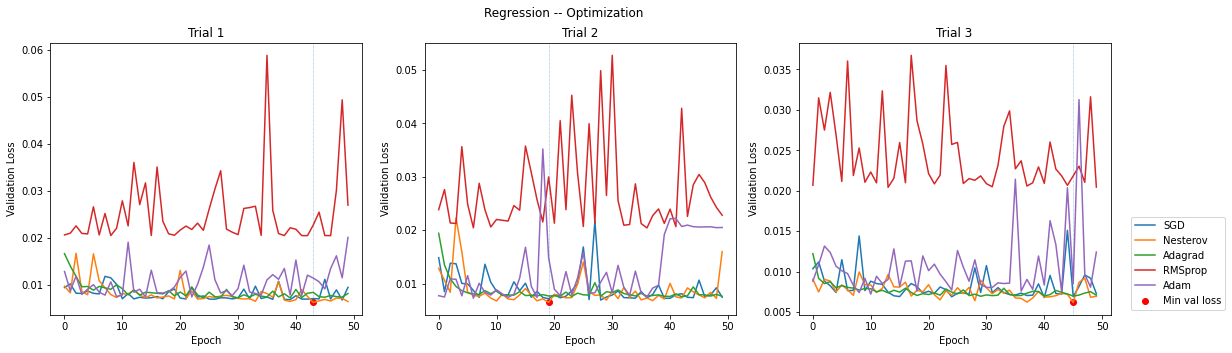

In [ ]:
opt_task(X_trn_community, y_trn_community, 50, 0, 64, 32, 1, 16, 0.1, 'linear', 'Log-cosh', 'logcosh', 'Regression')

# Regression -- Regularization Search
#### Using best loss function, hyperparameters, and optimizer

 found above

reg: None - lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: Nesterov
Epoch 50/50
Min val loss - 0.006  - Time 4.742- Epoch 27 
reg: WeightDecay - lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: Nesterov
Epoch 50/50
Min val loss - 0.007  - Time 6.346- Epoch 37 
reg: BatchNorm - lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: Nesterov
Epoch 50/50
Min val loss - 0.007  - Time 7.477- Epoch 33 
reg: Dropout - lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: Nesterov
Epoch 50/50
Min val loss - 0.008  - Time 7.36- Epoch 42 
reg: wd+BN+drop - lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: Nesterov
Epoch 50/50
Min val loss - 0.007  - Time 11.023- Epoch 49 
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='model_27/average_27/truediv:0', description="created by layer 'model_27'")
reg: Ensemble - lr: 0.1 - batch_size: 16, hidden units: (64,32) - opt: Nesterov
Epoch 50/50
Min val loss - 0.006  - Time 2.296- Epoch 0  


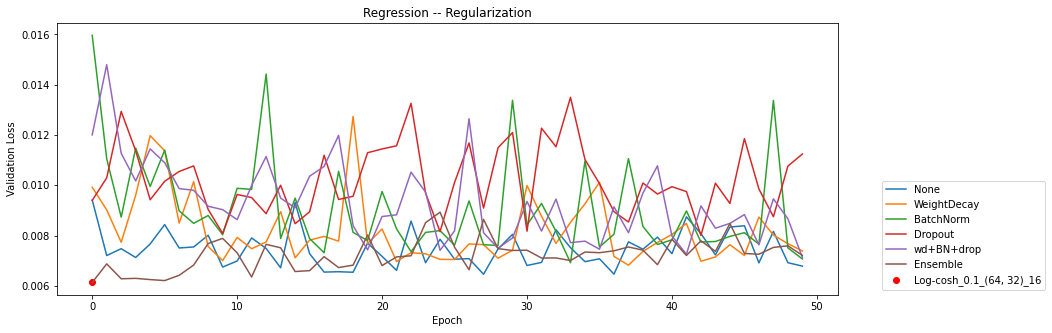


Earliest regularization method to converge: Ensemble


Epoch:      0
Time:       2.296 seconds
Loss_fn:    Log-cosh
Reg. type:  Ensemble
(h1,h2):    (64,32)
lr:         0.1
wgt. decay: 0
batch size: 16


Best loss score: 0.006


In [163]:
reg_task(X_trn_community, y_trn_community,'Regression','logcosh','Log-cosh', 0.1,16,64,32,1,'linear',50,'Nesterov',nesterov)

# Best regression model:



In [196]:
# The model can be found at this link:
#regression_model_url = 'https://drive.google.com/drive/u/0/folders/14TmARr74X2F8t11MzxkeVtwOVIz7BVO9'

best_reg_model = models.load_model(f'{regression_model_location}')


y_preds = best_reg_model(X_tst_community)
y_preds = [0 if row[0]<0.5 else 1 for row in y_preds]
y_tst_binary = [0 if row[0]<0.5 else 1 for row in y_tst_community]
acc = np.average([1 if y_preds[i]==y_tst_binary[i] else 0 for i in range(len(y_preds))])

print(f'Accuracy: {acc}')

Accuracy: 0.966
